In [60]:
from analyze_language_change import import_corpus, linear_prediction

import pandas as pd
from itertools import chain
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np 
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

In [61]:
corpus_12_25 = import_corpus(batch_size=100, streaming=False, url="julilili42/tagesschau")

In [54]:
corpus_18_23 = import_corpus(batch_size=100, streaming=False, url="bjoernp/tagesschau-2018-2023")
corpus_24 = import_corpus(batch_size=100, streaming=False, url="bjoernp/tagesschau-010124-020524")
corpus_17 = import_corpus(batch_size=100, streaming=False, url="julilili42/tagesschau-2017")

corpus = chain(corpus_17, corpus_18_23, corpus_24)

In [62]:
rows = [(a.date.year, a.article) for a in corpus_12_25]
year, articles = zip(*rows)

Generating train split: 100%|██████████| 404406/404406 [00:02<00:00, 141270.15 examples/s]


404406 articles to be loaded for dataset tagesschau


In [63]:
# generate word matrix 
vec = CountVectorizer(max_features=100000, binary=True)
word_matrix_bin = vec.fit_transform(articles)
vocab = vec.get_feature_names_out()

unique_years = np.unique(year)
# distribution of articles in unique years
year_distribution = defaultdict(int)

In [64]:
# dimension unique_years x vocab
rows = []

for y in unique_years:
    sel = (year == y)
    # number of articles in year y
    n = int(sel.sum())
    year_distribution[int(y)] = n
    
    # count how many articles (of this year) contain each word at least once -> dimension 1 x n 
    present_counts = np.asarray(word_matrix_bin[sel].sum(axis=0)).ravel()
    rows.append(present_counts / max(n, 1))

# occurence_freq per year
occurence_freq = pd.DataFrame(rows, index=unique_years, columns=vocab)

# goal: try to find words which disproportionaly increased in use 
# dataframe containing frequencies before introduction of llm's
train = occurence_freq.loc[2017:2022]

# linear interpolation, frequency value of 2024
q = train.apply(linear_prediction, axis=0)

# empirical frequency
p = occurence_freq.loc[2024]

# Metric 1: frequency gap delta = p - q
delta = p - q

# Metric 2: frequency ratio r = p/q
r = p / q.replace(0, 1e-8)
sorted_freq_gap = delta.sort_values(ascending=False).head(20)
sorted_freq_ratio = r.sort_values(ascending=False).head(20)

print(sorted_freq_gap)

eu               0.154456
2023             0.138989
us               0.121315
usa              0.116889
hatte            0.109327
2024             0.108020
raketen          0.107858
wahl             0.107556
europäischen     0.106995
israel           0.104800
hieß             0.104571
donald           0.102525
trump            0.096478
angriffe         0.094670
seine            0.094144
armee            0.092612
verhandlungen    0.092395
israelischen     0.091711
wahlkampf        0.090770
social           0.089919
dtype: float64


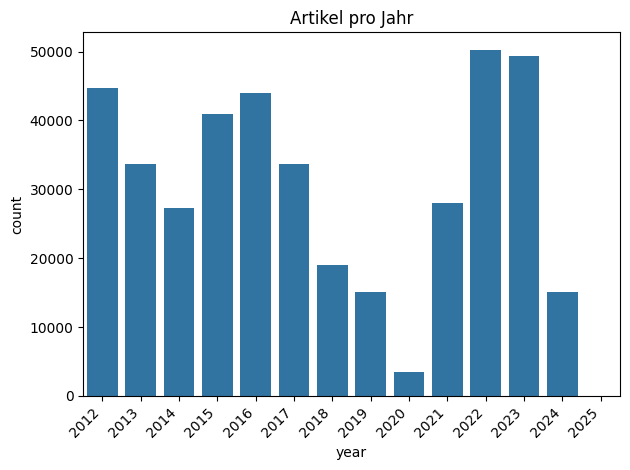

In [65]:
df_year = pd.DataFrame(
    list(year_distribution.items()), columns=["year", "count"]
  ).sort_values("year")

sns.barplot(data=df_year, x="year", y="count")
plt.xticks(rotation=45, ha="right")
plt.title("Artikel pro Jahr")
plt.tight_layout()
plt.show()